 # Прогнозирование статуса (закрыт/работает) стартапов

## Цель исследования

Цель - разработать модель прогнозирования статуса стартапа.

Прогноз должен быть выполнен в бинарном формате - закрыт/работает.

Качество модели оцениваем по метрике f1.

## Исходные данные

Датасет с тренировочной выборкой данных (далее train_data)  - содержит следующие данные:

- 'name' - имя компании/стартапа;
- 'category_list' - отрасль, в которой работает стартап;
- 'funding_total_usd' - общий объем финансирования, который был получен стартапом;
- 'status' - статус - закрыт/действует (таргет);
- 'country_code' - страна, где был зарегистрирован стартап;
- 'state_code' - код штата/региона, где был зарегистрирован стартап;
- 'region' - регион страны, где был зарегистрирован стартап;
- 'city' - город страны, где был зарегистрирован стартап;
- 'funding_rounds' - количество раундов финансирования, через которые прошел стартап;
- 'founded_at' - дата, когда был основан стартап;
- 'first_funding_at' - дата, когда было получено первое финансирование;
- 'last_funding_at' - дата, когда было получено последнее финансирование;
- 'closed_at' - дата закрытия (если стартап прекратил свое существование)

Датасет с тестовой выборкой данных (далее test_data)  - содержит следующие данные:
- 'name' - имя компании/стартапа;
- 'category_list' - отрасль, в которой работает стартап; 
- 'funding_total_usd' - общий объем финансирования, который был получен стартапом;
- 'country_code' - страна, где был зарегистрирован стартап;
- 'state_code'- код штата/региона, где был зарегистрирован стартап;
- 'region' - регион страны, где был зарегистрирован стартап;
- 'city' - город страны, где был зарегистрирован стартап;
- 'funding_rounds' - количество раундов финансирования, через которые прошел стартап;
- 'first_funding_at' - дата, когда было получено первое финансирование;
- 'last_funding_at' - дата, когда было получено последнее финансирование;
- 'lifetime' - время жизни стартапа.

## План исследования

1. Загрузка данных
2. Предобработка исходных данных
3. Исследовательский анализ данных, поиск аномалий
4. Разработка и тестирование модели прогнозирования
5. Формулирование выводов

# Исследование

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import phik

import sklearn
import lightgbm as lgb 
import shap 


In [2]:
# должно быть не выше 1.2.2
print(sklearn.__version__)

1.2.2


In [3]:
from scipy.stats import anderson



from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 42

In [4]:
# пользовательская функция для анализа данных числового типа 
# вычисляет для заданного датасета и его поля:
# (1) статистические характеристики;
# (2) создает гистограмму и (3) боксплот на общей оси x; 
# (4) выполняет тест Уилка-Шапиро на нормальность распределения значений 

def num_stat_description (dataset, col, bins, title):

    # задаем на полотне два графика, один под другим, с общей осью х
    fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(15, 7), sharex=True) 

    # (1) вычисляем статистические характеристики
    mean = dataset[col].mean()
    median = dataset[col].median()
    std = dataset[col].std()

    # (2) создаем гистограмму
    dataset[col].hist(bins=bins, label=col, ax=ax_hist)
        
    # наносим на гистограмму среднее и медиану 
    ax_hist.axvline(x=mean, color='red', linestyle='solid', linewidth=2, label=f'Mean: {mean:.2f}')
    ax_hist.axvline(x=median, color='orange', linestyle='solid', linewidth=2, label=f'Median: {median:.2f}')

    # наносим на гистограмму также и ско
    ax_hist.axvline(x=mean + std, color='green', linestyle='dashed', linewidth=2, label=f'+1Std: {std:.2f}')
    ax_hist.axvline(x=mean - std, color='green', linestyle='dashed', linewidth=2, label=f'-1Std: {-std:.2f}')
    
    ax_hist.axvline(x=mean + 2 * std, color='orange', linestyle='dashed', linewidth=2, label=f'+2Std: {2*std:.2f}')
    ax_hist.axvline(x=mean - 2 * std, color='orange', linestyle='dashed', linewidth=2, label=f'-2Std: {-2*std:.2f}')
    
    ax_hist.axvline(x=mean + 3 * std, color='red', linestyle='dashed', linewidth=2, label=f'+3Std: {3*std:.2f}')
    ax_hist.axvline(x=mean - 3 * std, color='red', linestyle='dashed', linewidth=2, label=f'-3Std: {-3*std:.2f}')


    # (3) боксплот (развернут горизонтально)
    boxplot = dataset.boxplot(column=col, vert=False, ax=ax_box)

    ax_hist.set_ylabel('Частота значений')
    ax_hist.legend(bbox_to_anchor=(1, 1))
    plt.suptitle(title)
    plt.show()

In [5]:
train_data = pd.read_csv('datasets\kaggle_startups_train_28062024.csv')

display(train_data.head(5))
train_data.info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


**Выводы по набору тренировочных данных (train_data):**

- всего 52 516 записей в датасете, 13 полей;
- предварительно данные соответствуют описанию;
- есть пропуски, в некоторых полях порядка 20% (например, funding_total);
- есть несоответствие типа данных: поля с датами имеют тип object (founded_at, closed_at, first_funding_at, last_funding_at);
- названия полей соответствуют змеиному стилю;
- неявных дублей пока не обнаружено.

In [6]:
test_data = pd.read_csv('datasets\kaggle_startups_test_28062024.csv')

display(test_data.head(5))
test_data.info()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


**Выводы по набору тестовых данных (test_data):**

- всего 13 125 записей в датасете, 11 полей;
- предварительно данные соответствуют описанию;
- есть пропуски, в некоторых полях порядка 20% (например, funding_total);
- есть несоответствие типа данных: поля с датами имеют тип object (first_funding_at, last_funding_at);
- названия полей соответствуют змеиному стилю;
- неявных дублей пока не обнаружено;

Также, стоить отметить (относительно  тренировочного датасета): 
- отсутствует поле status (что логично, мы его будем прогнозировать и это тестовая выборка), 
- отсутствует поле closed_at и founded_at, но есть поле lifetime, которое можно предположить и есть разница между closed_at и founded_at.

## Предобработка данных

Задачи этапа предобработки:
- проверка и устранение корректного наименования полей (здесь мы уже убедились, проблем нет);
- наличие полных дубликатов записей;
- проверка и устранение некорректных типов данных (поля с данными типа object, которые по факту содержат даты);
- проверка и устранение пропусков данных
- наличие неявных дубликатов значений (в текстовых полях)


### Проверка полных дубликатов записей:

In [7]:
display(train_data.duplicated().sum())
display(test_data.duplicated().sum())

0

0

Вывод: полных дубликатов записей нет.

### Преобразование типов данных 

In [8]:
# приведение к типу дата полей first_funding_at, last_funding_at в тренировочной выборке 
train_data['first_funding_at'] = pd.to_datetime(train_data['first_funding_at'], format='%Y-%m-%d')
train_data['last_funding_at'] = pd.to_datetime(train_data['last_funding_at'], format='%Y-%m-%d')

# приведение к типу дата полей founded_at, closed_at в тренировочной выборке 
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], format='%Y-%m-%d')
train_data['closed_at'] = pd.to_datetime(train_data['closed_at'], format='%Y-%m-%d')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

Можно заметить, что мы имеем большое количество пропусков в closed_at. Возможно это связано с тем, что там имеются данные по компаниям, которые закрыты, а по действующим - такой записи соответственно нет.

Проверим это:

In [9]:
train_data.query('status == "closed"')['closed_at'].isna().any()

False

In [10]:
train_data.query('status == "operating"')['closed_at'].isna().all()

True

Тем, не менее чтобы ввести аналогичное как в тестовой выборке поле lifetime, нам нужно некоторое условное значение для КАЖДОЙ компании, даже не закрытой, относительно которой мы будем считать lifetime (из чего будем вычитать founded_at).

Дата будет иметь условное значение в данном случае (это некоторый текущий момент, где мы проводим анализ по сути) - компания не закрыта, но мы анализируем срок жизни компании относительно ТЕКУЩЕГО МОМЕНТА и можем сравнивать со сроком жизни уже закрытых компаний.

Чтобы выбрать эту условную дату для заполнения closed_at (и сплошного расчета lifetime), посмотрим где у нас заканчиваются записи о закрытии. Так как если мы введем, текущую дату - 2024 год, то тогда lifetime действующих компаний может существенно отличаться от закрытых, в случае если, скажем, мы имеем данные только до 2015 года о закрытии - и это может скомпрометировать модель на тестовых данных затем).

In [11]:
train_data['closed_at'].max()

Timestamp('2017-10-21 00:00:00')

Самая поздняя запись у нас - за 2017 октябрь. Следовательно наша точка, в которой находится условный наблюдатель - это 2018, не позднее, иначе у нас были бы более актуальные данные.

Заполним тогда все пропуски в поле closed_at 2018-01-01, для расчета lifetime по всем компаниям:

In [12]:
train_data['closed_at'] = train_data['closed_at'].fillna('2018-01-01')
train_data['lifetime'] = train_data['closed_at'] - train_data['founded_at']

# преобразуем lifetime из времени в в целочисленный тип, выраженный в днях (аналогично тестовому набору данных)
train_data['lifetime'] = train_data['lifetime'].astype('int64') // 10**9 // 86400

Посмотрим теперь статистику значений этого поля в тестовом и тренировочном наборах данных:

In [13]:
train_data['lifetime'].describe()

count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

In [14]:
test_data['lifetime'].describe()

count    13125.000000
mean      3097.609524
std       2128.356554
min         52.000000
25%       1726.000000
50%       2526.000000
75%       3866.000000
max      17167.000000
Name: lifetime, dtype: float64

Как видим, они не имеют существенных отличий (среднее и отклонение практически идентичны), следовательно наш выбор с условной точкой ('2018-01-01') наблюдения и размерностью (дни, а не секунды или еще что-то) оказался верен.

Теперь приведем к типу дата данные, в тестовом наборе:

In [15]:
test_data['first_funding_at'] = pd.to_datetime(test_data['first_funding_at'], format='%Y-%m-%d')
test_data['last_funding_at'] = pd.to_datetime(test_data['last_funding_at'], format='%Y-%m-%d')

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


### Работа с пропусками

In [16]:
# проанализируем количество пропусков в данных
missing_data = pd.DataFrame(
    train_data.isna().mean()*100, columns=['Процент отсутствующих значений']
)

missing_data.sort_values('Процент отсутствующих значений', ascending=False).style.format('{:.1f}%') 

,Процент отсутствующих значений
funding_total_usd,19.2%
state_code,12.9%
region,12.1%
city,12.1%
country_code,10.5%
category_list,4.7%
name,0.0%
status,0.0%
funding_rounds,0.0%
founded_at,0.0%


После того, как мы заполнили пропуски в closed_at, самое большое количество пропущенных значений у нас теперь в поле funding_total_usd. 

В случае данного поля разумно будет предположить, что это компании, которые НЕ ПОЛУЧАЛИ финансирование от инвесторов вообще - поэтому здесь заполним пропуски нулем, вне зависимости от того, закрыта компания или еще работает.

В случае остальных полей - state_code, region, city, country_code, category_list - единственная стратегия здесь будет заполнить категорией "прочее", поскольку почерпнуть какую-то информацию о этих категориях из других полей мы не сможем.

Данные пропуски будем обрабатывать внутри пайплайна, поскольку аналогичные действия будем применять и к тестовому набору данных и это существенно упростит подготовку данных.

### Обработка полей с категориальными данными

#### Поле category_list

In [17]:
# проверим количество уникальных категорий в поле category_list тренировочного набора
pd.DataFrame(train_data['category_list'].unique(), columns=['categories']).sort_values(by='categories')

,categories
14125,3D
165,3D Printing
20707,3D Printing|3D Technology
18751,3D Printing|3D Technology|Android|Artificial I...
5317,3D Printing|3D Technology|Android|Games|iOS|Mo...
...,...
10705,mHealth
20410,mHealth|Mobile
8531,mHealth|Software
11495,mHealth|Software|Therapeutics


In [18]:
# проверим количество уникальных категорий в поле category_list тестового набора
pd.DataFrame(test_data['category_list'].unique()).sort_values(by=0)

,0
2021,3D Printing
261,3D Printing|3D Technology|Printing
5550,3D Printing|Art|Curated Web|Design|E-Commerce|...
6100,3D Printing|Cloud Computing|Consulting|E-Commerce
3919,3D Printing|Construction|Industrial
...,...
4282,iPhone|Mobile|Mobile Devices|Mobile Security|W...
3178,iPhone|Mobile|Navigation|Public Transportation...
2376,iPhone|Mobile|Social Media
516,iPhone|Mobile|Venture Capital


Здесь мы видим, что у нас ОЧЕНЬ БОЛЬШОЕ разнообразие уникальных значений в данном поле - 22 тыс из 52 тыс записей всего, то есть в среднем только две записи могут относится к одной категории. 

Далее, здесь может быть две стратегии:
- закодировать все уникальные значения как есть, а пропуски закодировать еще одним значением (базовый вариант - самый простой в реализации - но который будет нести, скорее всего, слабый вклад в качество модели);
- попробовать уменьшить разнообразие (вариант посложнее - выделить категории и подкатегории, которые указаны через разделитель).

Далее, здесь стоит отметить, что данные категории также слабо пересекаются между тестовым и тренировочным набором данных, всего 1243 общих элементов из порядка 10 тыс записей (всего лишь 12%) в тестовом наборе данных (что говорит в пользу варианта выделения корневых категорий и подкатегорий - в противном случае вклад этого признака в качество модели будет низким):

In [19]:
common_elements = len(list(set(test_data['category_list']) & set(train_data['category_list'])))
common_elements

1243

Разделим категории на подкатегории и вынесем их в отдельные поля:

In [20]:
# создадим функцию, которая разделяет строку по указанному разделителю 
# и полученные элементы записывает в отдельные поля

def split_column(df, column, new_columns, delimiter):
    
    # Разделяем строку на отдельные элементы
    split_data = df[column].str.split(delimiter, expand=True)
    
    # Присваиваем новые столбцы
    for i, new_column in enumerate(new_columns):
        df[new_column] = split_data[i]
    
    return df

# задаем новые столбцы
new_columns_1_level = ['1_category', '2_category', '3_category', '4_category', '5_category']

# разделяем категории
train_data = split_column(train_data, 'category_list', new_columns_1_level, delimiter ='|')

train_data.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,1_category,2_category,3_category,4_category,5_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,Online Reservations,Restaurants,None,None,None
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,Manufacturing,Medical,Medical Devices,None,None
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,Biotechnology,None,None,None,None


Добавим аналогичную обработку в тестовый набор:

In [21]:
test_data = split_column(test_data, 'category_list', new_columns_1_level, delimiter ='|')
test_data.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,1_category,2_category,3_category,4_category,5_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology,None,None,None,None
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,None,None,None,None
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,None,None,None,None


Теперь у нас в каждой категории порядка 500-700 элементов:

In [22]:
# количество уникальных элементов в каждой новой категории: 
print(len(train_data['1_category'].unique()))
print(len(train_data['2_category'].unique()))
print(len(train_data['3_category'].unique()))

708
779
737


Посмотрим теперь количество общих элементов подкатегорий между тренировочным и тестовым набором:

In [23]:
print (len(list(set(test_data['1_category']) & set(train_data['1_category']))))
print (len(list(set(test_data['2_category']) & set(train_data['2_category']))))
print (len(list(set(test_data['3_category']) & set(train_data['3_category']))))

540
606
544


Теперь у нас из порядка 500-700 элементов в каждой категории в тренировочной выборке, и порядка 300-600 - в тестовой соответственно, что делает более информативным этот признак для прогнозирования.

Мы также можем пойти далее, и разделить информацию об отраслях, на еще более мелкие фрагменты, используя отдельные слова, а в качестве разделителя уже - пробел:

In [24]:
# разделяем на слова в первой категории - тренировочная выборка
new_columns_2_level_1 = ['1_1_category', '1_2_category', '1_3_category']
train_data = split_column(train_data, '1_category', new_columns_2_level_1, delimiter =' ')

train_data.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,closed_at,lifetime,1_category,2_category,3_category,4_category,5_category,1_1_category,1_2_category,1_3_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,2018-01-01,2998,Online Reservations,Restaurants,None,None,None,Online,Reservations,None
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,2018-01-01,4748,Manufacturing,Medical,Medical Devices,None,None,Manufacturing,None,None
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,2018-01-01,4383,Biotechnology,None,None,None,None,Biotechnology,None,None


In [25]:
# разделяем на слова в первой категории - тестовая выборка
test_data = split_column(test_data, '1_category', new_columns_2_level_1, delimiter =' ')
test_data.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,1_category,2_category,3_category,4_category,5_category,1_1_category,1_2_category,1_3_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology,None,None,None,None,Clean,Technology,None
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,None,None,None,None,Hospitality,None,None
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,None,None,None,None,Finance,None,None


In [26]:
# разделяем на слова во второй категории - тренировочная выборка
new_columns_2_level_2 = ['2_1_category', '2_2_category', '2_3_category']
train_data = split_column(train_data, '2_category', new_columns_2_level_2, delimiter =' ')

train_data.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,2_category,3_category,4_category,5_category,1_1_category,1_2_category,1_3_category,2_1_category,2_2_category,2_3_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,Restaurants,None,None,None,Online,Reservations,None,Restaurants,None,None
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,Medical,Medical Devices,None,None,Manufacturing,None,None,Medical,None,None
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,None,None,None,None,Biotechnology,None,None,None,None,None


In [27]:
# разделяем на слова во второй категории - тестовая выборка
test_data = split_column(test_data, '2_category', new_columns_2_level_2, delimiter =' ')
test_data.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,2_category,3_category,4_category,5_category,1_1_category,1_2_category,1_3_category,2_1_category,2_2_category,2_3_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,...,None,None,None,None,Clean,Technology,None,None,None,None
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,None,None,None,None,Hospitality,None,None,None,None,None
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,None,None,None,None,Finance,None,None,None,None,None


In [28]:
# разделяем на слова в третьей категории - тренировочная выборка
new_columns_2_level_3 = ['3_1_category', '3_2_category', '3_3_category']
train_data = split_column(train_data, '3_category', new_columns_2_level_3, delimiter =' ')

train_data.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,5_category,1_1_category,1_2_category,1_3_category,2_1_category,2_2_category,2_3_category,3_1_category,3_2_category,3_3_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,None,Online,Reservations,None,Restaurants,None,None,None,None,None
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,None,Manufacturing,None,None,Medical,None,None,Medical,Devices,None
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,None,Biotechnology,None,None,None,None,None,None,None,None


In [29]:
test_data = split_column(test_data, '3_category', new_columns_2_level_3, delimiter =' ')
test_data.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,5_category,1_1_category,1_2_category,1_3_category,2_1_category,2_2_category,2_3_category,3_1_category,3_2_category,3_3_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,...,None,Clean,Technology,None,None,None,None,None,None,None
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,None,Hospitality,None,None,None,None,None,None,None,None
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,None,Finance,None,None,None,None,None,None,None,None


#### Поля с месторасположением (region, city)

В этих полях у нас есть ряд неявных дублей.
Выявление неявных дублей проводилось с помощью библиотеки fuzzywuzzy, и в виду достаточно медленного кода - выделено в отдельный блокнот в папке с проектом под названием duplicates.

Обработаем неявные дубликаты:

In [30]:
vocab = {

"Milan" : "Milano", 
"Melbourne" : "Melbourn", 
"Herzliya" : "Herzlia B", 
"Warsaw" : "Warszawa", 
"Bangkok" : "Bankok", 
"Brussels" : "Brussel", 
"Malmö" : "Malma", 
"West Palm" : "Beach Palm Beach", 
"Ahmedabad" : "Ahmadabad", 
"Lisbon" : "Lisboa", 
"Antwerp" : "Antwerpen", 
"Monterrey" : "Monterey", 
"Gent" : "Ghent", 
"Taiwan" : "Tainan", 
"St. John's" : "Saint John's", 
"Ness Ziona" : "Nes Ziyona", 
"Saint Gallen" : "Sankt Gallen", 
"Changsha CHN" : "Changshu", 
"Beijing" :" Beijin", 
"Shanghai" : "Shangai", 
"Milan" : "Milano", 
"Sofia" : "Sofiya", 
"Melbourne" :" Melbourn", 
"Tallinn" : "Tallinna", 
"Kuala Lumpur" : "Kuala Lumpor", 
"Bangkok" : "Bankok",  
"Brussels" : "Brussel", 
"Belo Horizonte" : "Bello Horizonte", 

}


train_data['city'] = train_data['city'].replace(vocab)

In [31]:
vocab = {

'Melbourne' : 'Melbourn',
'Montpellier' : 'Montpelier',
'Monterrey' : 'Monterey'

}


train_data['region'] = train_data['region'].replace(vocab)

In [32]:
test_data.shape

(13125, 25)

## Исследовательский анализ данных

### Таргет (status: компания работает или закрылась)

In [33]:
train_data['status'].value_counts(normalize=True)

status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64

Первое на что следует обратить внимание, это большой дисбаланс между классами в целевом признаке. 
Это означает, что для простых моделей (такие как дерево решений или логистическая регрессия) понадобится сэмплинг, для поднятия чувствительности модели к минорному классу.

### Объем финансирования (funding_total_usd)

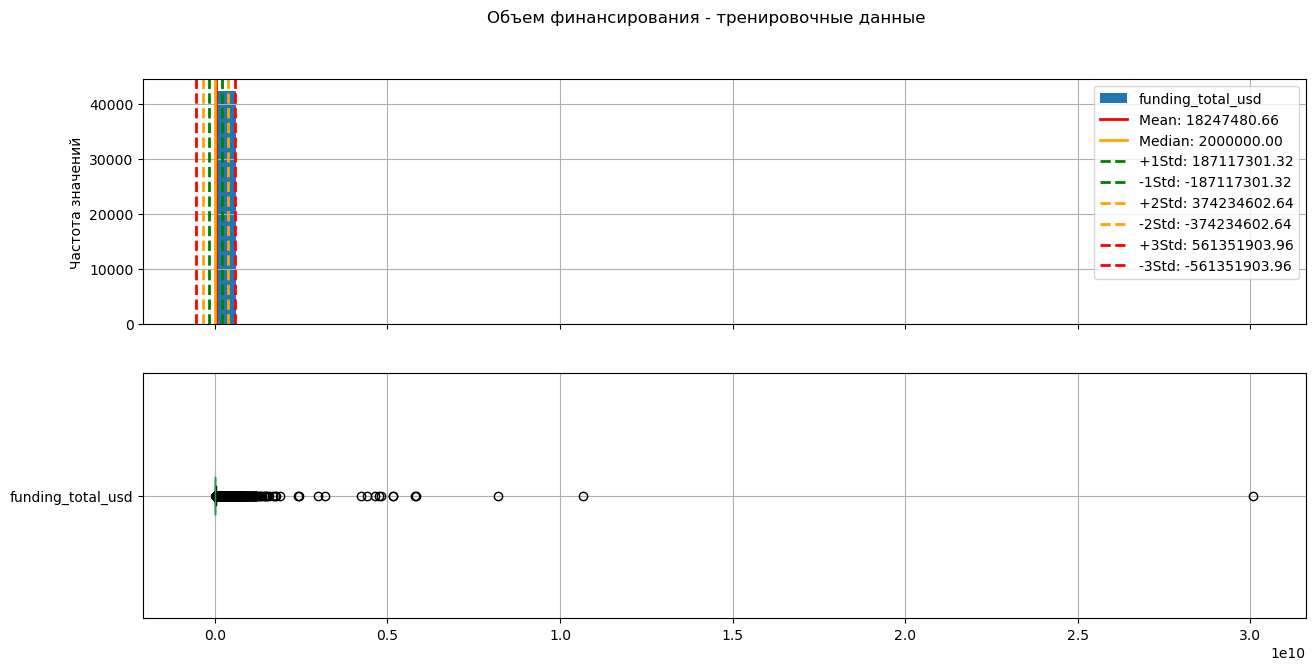

In [34]:
num_stat_description (train_data, "funding_total_usd", 50, "Объем финансирования - тренировочные данные")

У распределения есть очень большие выбросы относительно часто встречающихся значений - граница в три стандартных отклонения - 561 млн. долл, в то время как мы можем видеть значения в 50 и даже 300 млрд. долл (что на порядок больше 3 стандартных отклонений). 

Это означает что распределение с высокой долей вероятности не является нормальным, а значит линейные модели (логистическая регрессия будет плохо работать).

Проведеем тест на нормальное распределение данных, чтобы убедиться в этом однозначно:

In [35]:
# заполним нулями NaN, чтобы провести тесты
train_data["funding_total_usd_prep"] = train_data["funding_total_usd"].fillna(0)

result = anderson(train_data['funding_total_usd_prep'], dist='norm')
result

AndersonResult(statistic=16634.255214292163, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=14748853.90087872, scale=168378343.17941076)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [36]:
# интерпретация теста при уровне значимости 1%

if result.statistic < result.critical_values[4]:
    print("Выборка похожа на нормальное распределение (отвергаем нулевую гипотезу).")
else:
    print("Выборка не соответствует нормальному распределению (отвергаем нулевую гипотезу).")

Выборка не соответствует нормальному распределению (отвергаем нулевую гипотезу).


**Вывод:** данные в этом поле не распределены нормально

Далее, проведем тест на значимость разности средних (объема финансирования) между двумя классами, это поможет нам определиться, имеет ли данный признак какую-либо прогностическую значимость относительно таргета.

Для начала используем t-тест (его можно использовать, хотя с ограничением, на данных с ненормальным распределением):

In [37]:
# уровень статистической значимости теста
alpha = 0.01

# тест
results = st.ttest_ind(
    train_data.query('status == "closed"')["funding_total_usd_prep"], 
    train_data.query('status == "operating"')["funding_total_usd_prep"]
) 

# вывод результатов теста
print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

p-значение: 0.010908297817830457
Нет статистически значимых различий (не отвергаем нулевую гипотезу)


Как видим, согласно тесту Стьюдента, при уровне статистической значимости в 1%, мы не можем отвергнуть нулевую гипотезу (что средние двух групп равны). Но значение теста лежит достаточно близко к границе статистической значимости, всего лишь 0,0109. 

Проведем дополнительно также тест Манна-Уитни (этот тест даже больше нам подходит, поскольку его можно без каких-либо ограничений применять к данным с ненормальным распределением):

In [38]:
from scipy.stats import mannwhitneyu

# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data.query('status == "closed"')["funding_total_usd_prep"], 
    train_data.query('status == "operating"')["funding_total_usd_prep"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 107506849.5
p-значение: 3.899387649714552e-21
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Согласно же теста Манна-Уитни имеется статистически значимая разница средних - значения теста весьма уверенные, и не являются пограничными, даже для 1% уровня стастической значимости. 

**Выводы:**
- уровень полученного финансирования, скорее всего, может иметь существенный вклад при прогнозировании закрытия стартапа. 

Посмотрим теперь на распределение значений в тестовой выборке по этому полю:

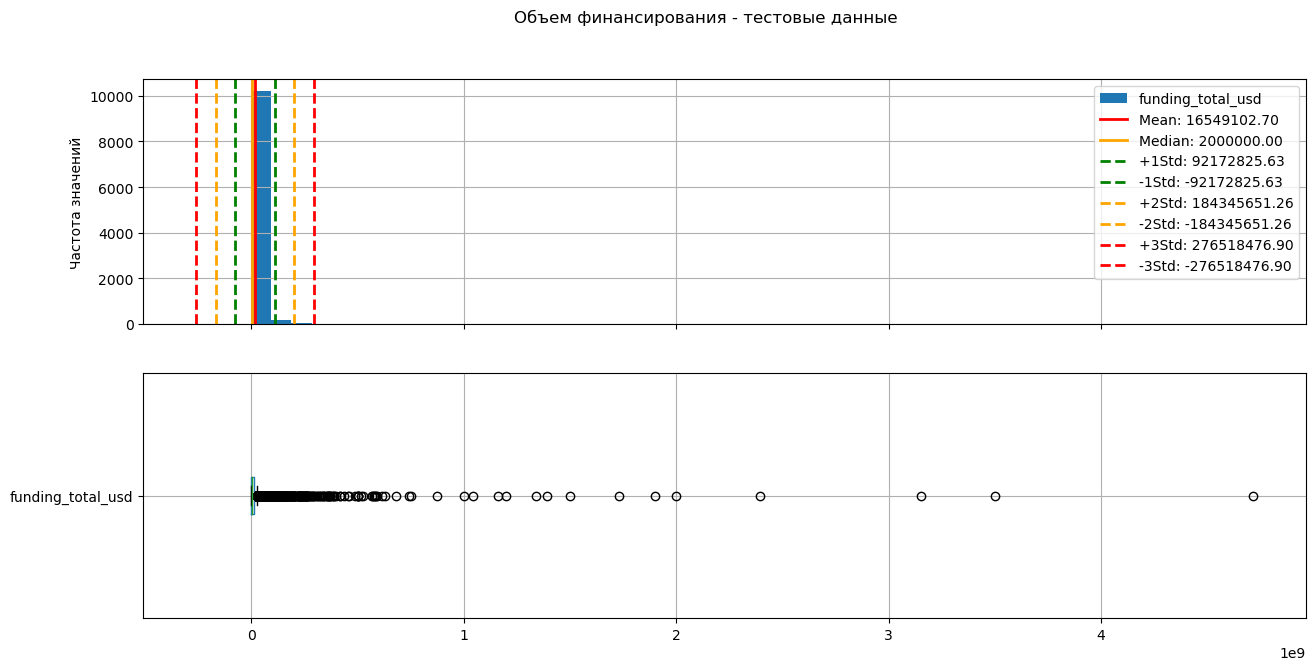

In [39]:
num_stat_description (test_data, "funding_total_usd", 50, "Объем финансирования - тестовые данные")

Здесь мы можем видеть, что характер распределения, уровня финансирования, имеет сходный характер - такой же тяжелый хвост справа. 

Но стоит также отметить, что:
- среднее значение в тренировочной выборке выше - 18,2 млн против 16,5 млн;
- стандартное отклонение в тренировочной выборке выше - больше 187 млн против 92 млн., т. е. в ней еще больше выбросов. 

Различие в стандартных отклонениях между тренировочной и тестовой выборками может существенно повлиять на результаты модели и привести к переобучению.

Проведем поэтому тест на разность средних тренировочной и тестовой выборки:

In [40]:
# заполним нулями NaN, чтобы провести тесты
test_data["funding_total_usd_prep"] = train_data["funding_total_usd"].fillna(0)

from scipy.stats import mannwhitneyu

# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data["funding_total_usd_prep"], 
    test_data["funding_total_usd_prep"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 346849218.0
p-значение: 0.2527358106585238
Нет статистически значимых различий (не отвергаем нулевую гипотезу)


Средние значения уровня финансирования в тренировочной и тестовой выборке сходны.

Проведем также тест на разность дисперсий с помощью бутстрапирования:

In [41]:
sample1 = train_data['funding_total_usd_prep']
sample2 = train_data['funding_total_usd_prep']

# Размер бутстрэп-выборки
n_bootstrap_samples = 10000

# Создаем пустой массив для хранения разностей дисперсий
bootstrap_std_1 = []
bootstrap_std_2 = []

# Генерируем бутстрэп-выборки и вычисляем разности дисперсий
for i in range(n_bootstrap_samples):
    bootstrap_sample1 = np.random.choice(sample1, size=1000, replace=True)
    bootstrap_sample2 = np.random.choice(sample2, size=1000, replace=True)
    
    bootstrap_std_1.append(np.std(bootstrap_sample1)) 
    bootstrap_std_2.append(np.std(bootstrap_sample2)) 

In [42]:
# уровень статистической значимости теста
alpha = 0.01

# тест
results = st.ttest_ind(
    bootstrap_std_1, 
    bootstrap_std_2
) 

# вывод результатов теста
print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

p-значение: 0.7296974259971503
Нет статистически значимых различий (не отвергаем нулевую гипотезу)


Как выдим, статистической значимости разницы между двумя стандартными отклонениями (тренировочной и тестовой выборки) нет. Это означает, что визуально наблюдаемая разница нами является случайной. 

**Вывод**:
Данные, которые мы имеем по funding_total_usd сходны и в части среднего значения, и в части меры разброса.

Мы можем провести еще одно наглядное упражнение для подтверждения тезиса выше:

In [43]:
train_data['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [44]:
train_data_without_outliers = train_data.query('funding_total_usd < 5_000_000_000')

In [45]:
train_data_without_outliers['funding_total_usd'].describe()

count    4.244000e+04
mean     1.658026e+07
std      8.152412e+07
min      1.000000e+00
25%      3.360000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.812000e+09
Name: funding_total_usd, dtype: float64

In [46]:
test_data['funding_total_usd'].describe()

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64

Достаточно отбросить несколько значений справа от среднего в тренировочной выборке, как стандартное отклонение визульно будет уже близко к стандартному отклоенению тестовой выборки. Следовательно здесь играет пара выбросов которые мы видели на гистограмме выше.

**Выводы:**
- признак funding_total_usd имеет влияние на таргет;
- значения не распределены нормально (логрегрессия нам не подойдет);
- значения в тренировочной и тестовой выборке распределены схожим образом.

*Примечание. Поскольку в данной задаче нам недоступны значения таргета для тестовой выборки, то в случае если была бы статистически значимая разница в распределении значений этого поля между тренировочной и тестовой выборкой, нам пришлось бы трансформировать тренировочную выборку определенным образом, чтобы убрать из нее записи менее похожие на значения из тестовой, оставив более близкие к тестовой.*

### Время существования (lifetime)

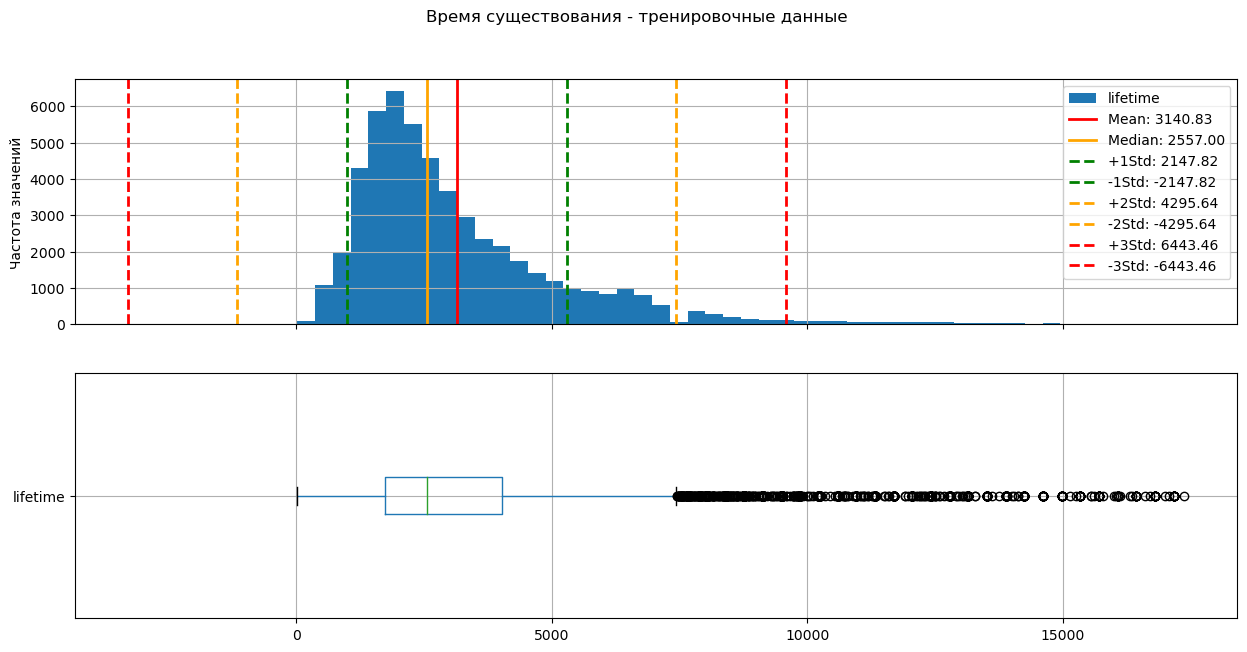

In [47]:
num_stat_description (train_data, "lifetime", 50, "Время существования - тренировочные данные")

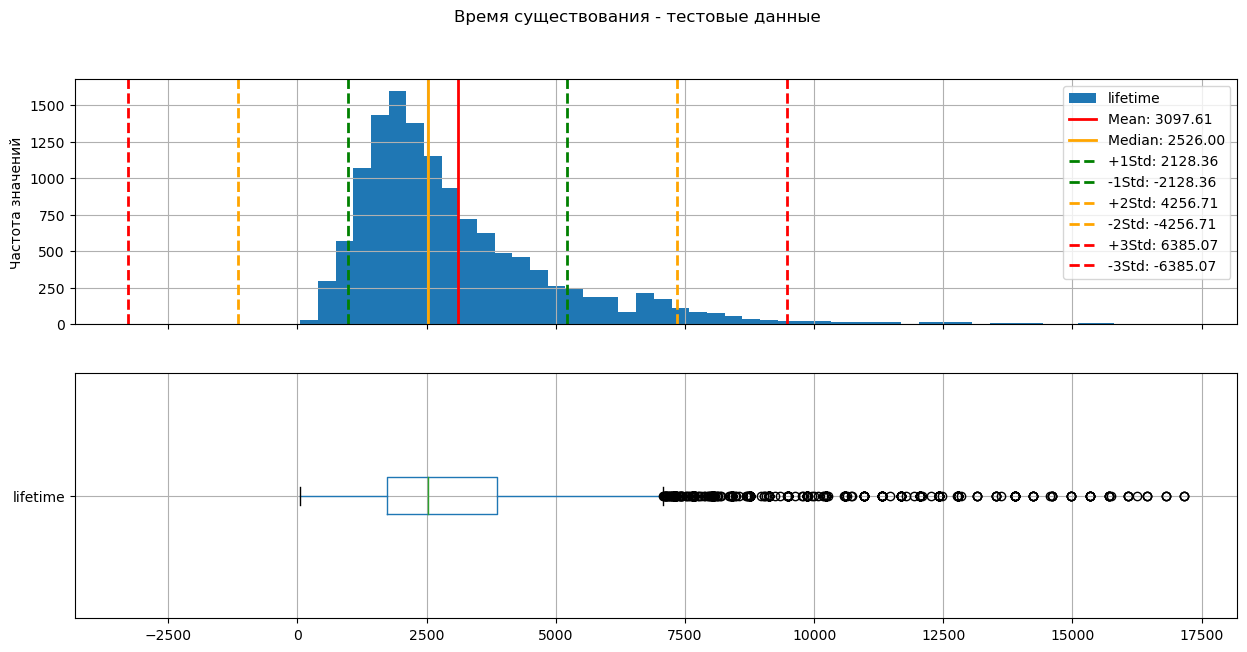

In [48]:
num_stat_description (test_data, "lifetime", 50, "Время существования - тестовые данные")

В поле lifetime распределение значений имеет также длинный тяжелый хвост справа, хотя и не столь ярко выраженный - мы можем рассмотреть по крайней мере здесь основные, часто встречающиеся значения - в отличие от предыдущего поля. 

Также можно видеть, что данные в поле lifetime  в тестовой выборке имеют похожую с тренировочной структуру: 
- средние значения практически идентичны (3140 дней против 3097 дней);
- стандартные отклонения также идентичны (2147 дней против 2128 дней).

Проведем тест на нормальное распределение:

In [49]:
result = anderson(train_data['lifetime'], dist='norm')
result

AndersonResult(statistic=2285.6633654520774, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3140.8281285703406, scale=2147.821069564776)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [50]:
# интерпретация теста при уровне значимости 1%

if result.statistic < result.critical_values[4]:
    print("Выборка похожа на нормальное распределение (отвергаем нулевую гипотезу).")
else:
    print("Выборка не соответствует нормальному распределению (отвергаем нулевую гипотезу).")

Выборка не соответствует нормальному распределению (отвергаем нулевую гипотезу).


Значения не распределены нормально.

Далее, проведем тест на значимость разности средних (объема финансирования) между двумя классами, это поможет нам определиться, имеет ли данный признак какую-либо прогностическую значимость относительно таргета.

In [51]:
# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data.query('status == "closed"')["lifetime"], 
    train_data.query('status == "operating"')["lifetime"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 28098651.5
p-значение: 0.0
Есть статистически значимые различия (отвергаем нулевую гипотезу)


**Вывод**:
- основываясь на результатах теста Манна-Уитни можем утверждать, что данный фактор (срок существования) является еще более существенным в определении статуса стартапа (чем объем финансирования), судя по значению статистики Манна-Уитни.

Тест на разность средних между тренировочной и тестовой выборкой в данном поле:

In [52]:
from scipy.stats import mannwhitneyu

# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data["lifetime"], 
    test_data["lifetime"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 348680153.5
p-значение: 0.03726439963006546
Нет статистически значимых различий (не отвергаем нулевую гипотезу)


**Выводы:**
- признак lifetime имеет влияние на таргет;
- значения не распределены нормально;
- значения в тренировочной и тестовой выборке распределены схожим образом.

### Количество раундов финансирования (funding_rounds)

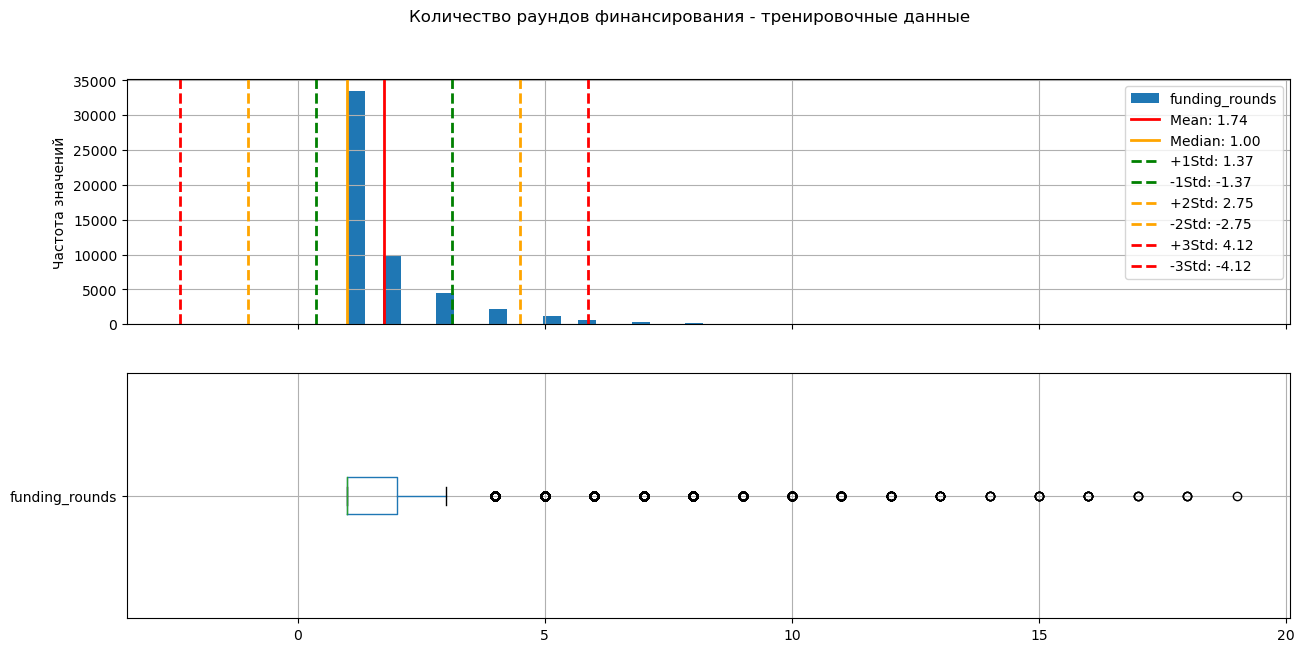

In [53]:
num_stat_description (train_data, "funding_rounds", 50, "Количество раундов финансирования - тренировочные данные")

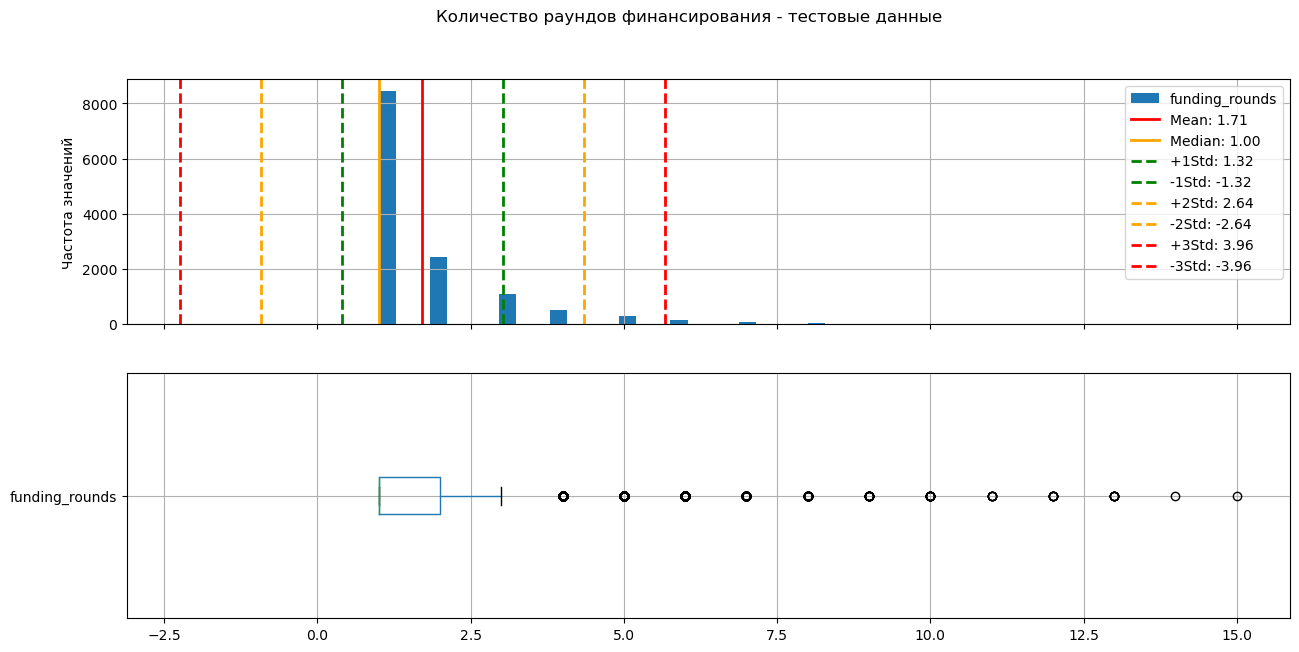

In [54]:
num_stat_description (test_data, "funding_rounds", 50, "Количество раундов финансирования - тестовые данные")

Здесь можно видеть, что данные в этом поле имеют дискретный характер (собственно об этом говорит и тип данных поля - integer):

- больше всего (порядка 35 тыс из 52) стартапов имели в своей истории только 1 раунд привлечения средств;
- порядка 10 тыс - имели 2 раунда;
- 5 тыс - 3 раунда;
- 4 раунда и более уже уже встречаются редко относительно други и отмечены как выбросы, за пределами межквартильного размаха;

Данные в тестовой выборке имеют похожую с тренировочной структуру: 
- средние значения практически идентичны (1.74 раунда против 1.71 раунда);
- стандартные отклонения также практически идентичны (1.37 дней против 1.31 дней).

Тест на статистическую значимость разности средних между группами closed/operating по этому признаку:

In [55]:
# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data.query('status == "closed"')["funding_rounds"], 
    train_data.query('status == "operating"')["funding_rounds"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 99191449.0
p-значение: 4.912113455718185e-94
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Данный признак также имеет существенное влияние на таргет.

Тест на разность средних между тренировочной и тестовой выборкой по этому признаку:

In [56]:
from scipy.stats import mannwhitneyu

# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data["funding_rounds"], 
    test_data["funding_rounds"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 347007902.5
p-значение: 0.15342111966629599
Нет статистически значимых различий (не отвергаем нулевую гипотезу)


**Выводы:**
- признак funding_rounds имеет влияние на таргет;
- значения не распределены нормально;
- значения в тренировочной и тестовой выборке распределены схожим образом.

### Добавление новых признаков

У нас есть еще два поля - это дата получения первого финансирования (раунда), и дата последнего раунда.
На их основе мы можем добавить еще как минимум три новых признака:

- funding_lasting - как долго длится период финансирования (по идее, если раундов несколько, то значит стартап развивается)
- how_long_ago_first_funding - как много времени (относительно нашей условной точки наблюдения - на начало 2018 года) прошло с момента первого раунда;
- how_long_ago_last_funding - как много времени (относительно нашей условной точки наблюдения - на начало 2018 года) прошло с момента последнего раунда.

In [57]:
# добавляем funding_lasting
train_data['funding_lasting'] = (train_data['last_funding_at'] - train_data['first_funding_at']
                                ).astype('int64') // 10**9 // 86400

test_data['funding_lasting'] = (test_data['last_funding_at'] - test_data['first_funding_at']
                                ).astype('int64') // 10**9 // 86400

In [58]:
# добавляем how_long_ago_first_funding и how_long_ago_last_funding
# в тренировочную и тестовую выборки

train_data['end'] = '2018-01-01'
test_data['end'] = '2018-01-01'

train_data['end'] = pd.to_datetime(train_data['end'], format='%Y-%m-%d')
test_data['end'] = pd.to_datetime(train_data['end'], format='%Y-%m-%d')


train_data ['how_long_ago_first_funding'] = (train_data['end'] - train_data['first_funding_at']
                                            ).astype('int64') // 10**9 // 86400

train_data ['how_long_ago_last_funding'] = (train_data['end'] - train_data['last_funding_at']
                                           ).astype('int64') // 10**9 // 86400


test_data ['how_long_ago_first_funding'] = (test_data['end'] - test_data['first_funding_at']
                                            ).astype('int64') // 10**9 // 86400

test_data ['how_long_ago_last_funding'] = (test_data['end'] - test_data['last_funding_at']
                                           ).astype('int64') // 10**9 // 86400

In [59]:
# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data.query('status == "closed"')["funding_lasting"], 
    train_data.query('status == "operating"')["funding_lasting"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 99202436.0
p-значение: 1.1848989599615385e-93
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Новый признак "как долго длился период финансирования" играет существенную роль в прогнозировании таргета.

In [60]:
train_data.query('status == "closed"')["funding_lasting"].describe()

count    4917.000000
mean      181.572707
std       471.182493
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4353.000000
Name: funding_lasting, dtype: float64

In [61]:
train_data.query('status == "operating"')["funding_lasting"].describe()

count    47599.000000
mean       363.524927
std        705.074459
min          0.000000
25%          0.000000
50%          0.000000
75%        465.000000
max      10807.000000
Name: funding_lasting, dtype: float64

Как видим, у компаний которые продолжают работать, этот признак - длительность финансирования составляет в среднем 363 дня, против 181 день у компаний, которые закрылись.

In [62]:
# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data.query('status == "closed"')["how_long_ago_first_funding"], 
    train_data.query('status == "operating"')["how_long_ago_first_funding"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 144019891.0
p-значение: 8.948244960544549e-157
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Новый признак "как давно был первый раунд финансирования" играет существенную роль в прогнозировании таргета.

In [63]:
train_data.query('status == "closed"')["how_long_ago_first_funding"].describe()

count     4917.000000
mean      2898.166565
std       1578.127833
min        759.000000
25%       1675.000000
50%       2701.000000
75%       3798.000000
max      13071.000000
Name: how_long_ago_first_funding, dtype: float64

In [64]:
train_data.query('status == "operating"')["how_long_ago_first_funding"].describe()

count    47599.000000
mean      2304.188344
std       1281.341158
min        758.000000
25%       1358.000000
50%       1933.000000
75%       2922.000000
max      14841.000000
Name: how_long_ago_first_funding, dtype: float64

Как видим, у компаний которые продолжают работать, этот признак - как давно было получено первое финансирование -  составляет в среднем 2304 дней, против 2898 дней у компаний которые закрылись.

In [65]:
# уровень статистической значимости теста
alpha = 0.01

# тест
stat, p = mannwhitneyu(
    train_data.query('status == "closed"')["how_long_ago_last_funding"], 
    train_data.query('status == "operating"')["how_long_ago_last_funding"]
)

print('Статистика U:', stat)
print('p-значение:', p)

if p < alpha:
    print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
else:
    print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

Статистика U: 155640702.5
p-значение: 0.0
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Новый признак "как давно был последний раунд финансирования" играет существенную роль в прогнозировании таргета.

In [66]:
train_data.query('status == "closed"')["how_long_ago_last_funding"].describe()

count     4917.000000
mean      2716.593858
std       1538.036637
min        759.000000
25%       1512.000000
50%       2467.000000
75%       3562.000000
max      13071.000000
Name: how_long_ago_last_funding, dtype: float64

In [67]:
train_data.query('status == "operating"')["how_long_ago_last_funding"].describe()

count    47599.000000
mean      1940.663417
std       1161.201599
min        756.000000
25%       1127.000000
50%       1538.000000
75%       2392.000000
max      14841.000000
Name: how_long_ago_last_funding, dtype: float64

Как видим, у компаний которые продолжают работать, этот признак - как давно было получено первое финансирование -  составляет в среднем 1940 дней, против 2716 дня у компаний которые закрылись.

**Выводы:**
- новые признаки вероятно имеют также существенную роль в прогнозировании таргета;
- при этом логика у них, скорее всего следующая: чем дольше был период финансирования (то есть, что аналогично было несколько раундов) - тем выше вероятность что компания все еще существует; чем относительно недавно компания получила первое (и последнее/крайнее) финансирование - тем выше вероятность что компания еще существует (здесь банальная вещь - стартапы долго не живут - и чем раньше они были основаны, тем выше вероятность их закрытия при прочих равных, скорее всего).

### Корреляционный анализ

In [68]:
train_data.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'lifetime',
       '1_category', '2_category', '3_category', '4_category', '5_category',
       '1_1_category', '1_2_category', '1_3_category', '2_1_category',
       '2_2_category', '2_3_category', '3_1_category', '3_2_category',
       '3_3_category', 'funding_total_usd_prep', 'funding_lasting', 'end',
       'how_long_ago_first_funding', 'how_long_ago_last_funding'],
      dtype='object')

In [69]:
train_data[[
    
    'status',
    
    'country_code',
    'state_code', 
    'region', 
    'city',
   
    'funding_total_usd',
    'lifetime',
    'funding_rounds',
    'funding_lasting',
    'how_long_ago_first_funding', 
    'how_long_ago_last_funding'

    ]].phik_matrix(interval_cols=['funding_total_usd', 
                                  'lifetime', 
                                  'funding_rounds', 
                                  'funding_lasting',
                                  'how_long_ago_first_funding', 
                                  'how_long_ago_last_funding'])

C:\Users\Алекс\AppData\Roaming\Python\Python311\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable city is large: 4457. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
C:\Users\Алекс\AppData\Roaming\Python\Python311\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1033. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


,status,country_code,state_code,region,city,funding_total_usd,lifetime,funding_rounds,funding_lasting,how_long_ago_first_funding,how_long_ago_last_funding
status,1.000000,0.124833,0.114905,0.131077,0.041353,0.000000,0.535217,0.098707,0.058833,0.180430,0.244593
country_code,0.124833,1.000000,0.993440,1.000000,0.999994,0.000000,0.190580,0.000000,0.000000,0.149673,0.103723
state_code,0.114905,0.993440,1.000000,0.999927,0.999990,0.000000,0.254898,0.000000,0.000000,0.151780,0.063564
region,0.131077,1.000000,0.999927,1.000000,1.000000,0.000000,0.351591,0.067875,0.000000,0.123556,0.039681
city,0.041353,0.999994,0.999990,1.000000,1.000000,0.000000,0.646764,0.000000,0.000000,0.428808,0.448336
funding_total_usd,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.116706,0.213825,0.036073,0.098080,0.076524
lifetime,0.535217,0.190580,0.254898,0.351591,0.646764,0.116706,1.000000,0.250854,0.287786,0.670207,0.567785
funding_rounds,0.098707,0.000000,0.000000,0.067875,0.000000,0.213825,0.250854,1.000000,0.488776,0.268915,0.148506
funding_lasting,0.058833,0.000000,0.000000,0.000000,0.000000,0.036073,0.287786,0.488776,1.000000,0.476014,0.065085
how_long_ago_first_funding,0.180430,0.149673,0.151780,0.123556,0.428808,0.098080,0.670207,0.268915,0.476014,1.000000,0.994711


Мы можем видеть, что между статусом стартапа и:

- продолжительностью его существования есть положительная корреляция средней силы - 0,53;

- продолжительностью времени с момента последнего раунда есть положительная корреляция слабой силы - 0,24;
- продолжительностью времени с момента первого раунда есть положительная корреляция слабой силы - 0,18;
- продолжительностью времени финансирования есть положительная корреляция слабой силы - 0,05;

- количеством раундов финансирования есть положительная корреляция слабой силы - 0,09;

- страной происхождения есть положительная корреляция слабой силы - 0,12;
- штатом/регионом происхождения есть положительная корреляция слабой силы - 0,11;
- регионом происхождения есть положительная корреляция слабой силы - 0,13;
- городом происхождения есть положительная корреляция слабой силы - 0,05;

- и объемом полученного финансирования отсутствует корреляция (то есть нет линейной взаимосвязи).


Также можно отметить что есть сильная мультиколлинеарность между
- признаками местанахождения (страна/штат/регион/город) - коэффициент корреляции составляет 0,99-1,00 в этом случае; 
- новыми признаками - как много времени прошло с момента первого и последнего раунда.

И это, опять-таки может быть существенно проблемой для линейных моделей.

Попробуем оценить, какого характера может быть зависимость между вероятностью выживания и объемом финансирования (где у нас нулевая корреляция):

In [70]:
# категоризируем таргет 
train_data ['status_prep'] = train_data ['status'].apply(lambda x: 1 if x == 'operating' else 0)

In [71]:
# сгруппируем данные по объему финансирования в корзины/группы для наглядности
train_data['funding_total_usd_bins'] = pd.cut(train_data['funding_total_usd_prep'], bins=100)

In [72]:
sum_table = pd.DataFrame(
    train_data.pivot_table(index='funding_total_usd_bins', values='status_prep', aggfunc=['count', 'mean']))

sum_table.columns = ['количество', 'вероятность выживания']

sum_table = sum_table.reset_index()

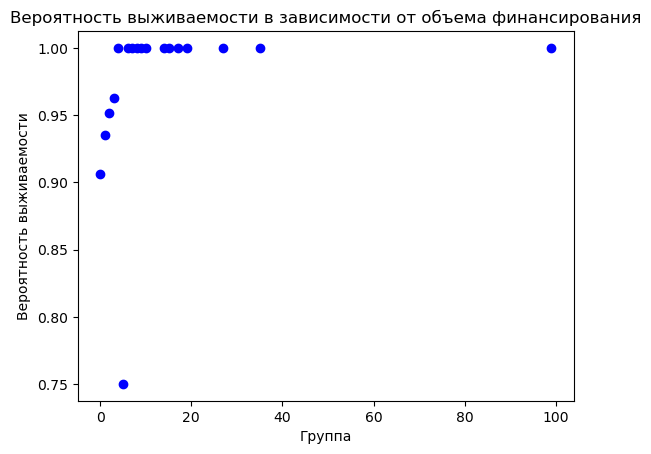

In [73]:
plt.scatter(
        sum_table.index,  
        sum_table['вероятность выживания'],
        marker='o',
        label='Среднее значение внутри группы',

        color='blue'
    )

plt.ylabel('Вероятность выживаемости')
plt.xlabel('Группа')
plt.title('Вероятность выживаемости в зависимости от объема финансирования')
plt.show()

В таком масштабе, пожалуй ничего не видно, из-за того что у нас много выбросов. 

Посмотрим на основной диапазон, где находятся 99% значений (до 600 млн. долл, или грубо 3 стандартных отклоненния):

In [74]:
# сгруппируем данные по объему финансирования в корзины/группы для наглядности

train_data_no_outliers = train_data.query('funding_total_usd_prep < 600_000_000')


train_data_no_outliers['funding_total_usd_bins'] = pd.cut(train_data_no_outliers['funding_total_usd_prep'], bins=100)

sum_table = pd.DataFrame(
    train_data_no_outliers.pivot_table(index='funding_total_usd_bins', values='status_prep', aggfunc=['count', 'mean']))

sum_table.columns = ['количество', 'вероятность выживания']

C:\Users\Алекс\AppData\Local\Temp\ipykernel_8836\2611385569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_no_outliers['funding_total_usd_bins'] = pd.cut(train_data_no_outliers['funding_total_usd_prep'], bins=100)


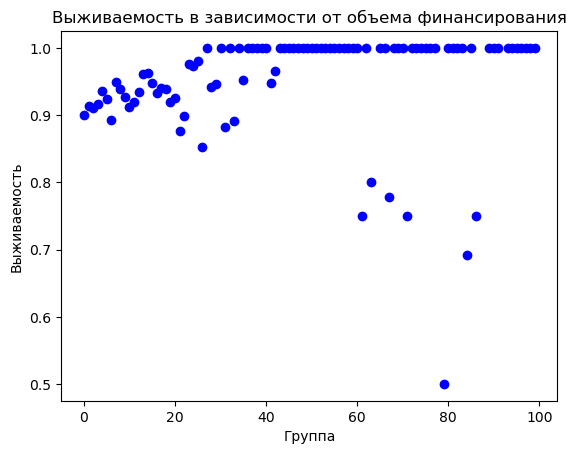

In [75]:
sum_table = sum_table.reset_index()

bars = plt.scatter(
        sum_table.index,  
        sum_table['вероятность выживания'],
        marker='o',
        label='Среднее значение внутри группы',

        color='blue'
    )

plt.ylabel('Выживаемость')
plt.xlabel('Группа')
plt.title('Выживаемость в зависимости от объема финансирования')

plt.show()

Пояснение.
По оси ординат - вероятность выживания (от 0 до 1);
По оси абсцисс - отнормированные значения объема финансирования (от 0 до 600 млн), разложенные в 100 групп, равных по величине; то есть каждая группа - это отрезок в 6 млн, или что тоже самое - % от 600 млн долл.


В общем, можно сказать что зависимость крайне запутанная, точно не линейная, и сложно описать характер этой нелинейности:

- первые 20% значений от всего диапазона значений (объема полученного финансирования) - вероятность выживаемости  растет, можно сказать по квадратичной зависимости (порядка 1/2 степени), но при этом некоторые группы "проваливаются вниз" от предполагаемого графика этой зависимости, и чем дальше к группе 40 - тем чаще это происходит;
- районе группы 40 вероятность выживаемости практически приближается к 1, но тем не менее - там слуаются еще большие провалы - некоторые корзины имеют выживаемость на уровне 0,8-0,7. Но скорее всего это объясняется тем, что количество наблюдений там уже небольшое, и статистика неустойчивая. 

То есть с ростом величины привлеченного капитала, вероятность выживания растет, но случаются крайне неприятные сюрпризы на этом пути. 

## Модель

In [76]:
train_data.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'lifetime',
       '1_category', '2_category', '3_category', '4_category', '5_category',
       '1_1_category', '1_2_category', '1_3_category', '2_1_category',
       '2_2_category', '2_3_category', '3_1_category', '3_2_category',
       '3_3_category', 'funding_total_usd_prep', 'funding_lasting', 'end',
       'how_long_ago_first_funding', 'how_long_ago_last_funding',
       'status_prep', 'funding_total_usd_bins'],
      dtype='object')

In [77]:
# создаём списки с названиями входящих признаков для модели
# номинальные категориальные
ord_columns = [

    '1_category',
    
    '1_1_category', 
    '1_2_category', 
  
    
    '2_category',
    
    '2_1_category', 
    '2_2_category', 

    
    '3_category',
    '4_category',

    'country_code',
    'state_code', 
    'region',
    'city'
 
]

# количественные
num_columns = [

    'funding_total_usd',
    'lifetime',
    'funding_rounds',
    'funding_lasting',
    
    'how_long_ago_first_funding',
    'how_long_ago_last_funding'
    
]

all_input_features = ord_columns + num_columns

# разделяем входящие признаки и таргет в тренировочном датасете
X = train_data[all_input_features]
y = train_data['status']

# кодируем таргет
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

In [78]:
# Предобработка категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer2', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1))
])

# Предобработка числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', 'passthrough')  
])

# Объединение предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ord_columns),
        ('num', numeric_transformer, num_columns),
    ])

# Создание пайплайна с моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('models', LGBMClassifier())
])

In [79]:
# cловари гиперпараметров для моделей
param_grid = [

     {
        'models': [CatBoostClassifier(random_state=42)],
        'models__iterations': [100],
        'models__learning_rate': [0.1],
        'models__depth': [5],
        'models__l2_leaf_reg': [1],
 
       
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
    
]

In [80]:
# поиск лучшей модели и ее гиперпараметров
model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)

model.fit(X, y)
print(f'Лучшая модель: {model.best_estimator_.named_steps["models"]}')
print(f'Метрика f1 лучшей модели по результатам кросс-валидации: {round(model.best_score_, 2)}')

0:	learn: 0.6104491	total: 144ms	remaining: 14.2s
1:	learn: 0.5428441	total: 150ms	remaining: 7.33s
2:	learn: 0.4863066	total: 155ms	remaining: 5.01s
3:	learn: 0.4394548	total: 161ms	remaining: 3.86s
4:	learn: 0.3981080	total: 166ms	remaining: 3.16s
5:	learn: 0.3621329	total: 172ms	remaining: 2.7s
6:	learn: 0.3321101	total: 177ms	remaining: 2.35s
7:	learn: 0.3066404	total: 182ms	remaining: 2.09s
8:	learn: 0.2839601	total: 188ms	remaining: 1.9s
9:	learn: 0.2637370	total: 193ms	remaining: 1.74s
10:	learn: 0.2458903	total: 199ms	remaining: 1.61s
11:	learn: 0.2303320	total: 204ms	remaining: 1.5s
12:	learn: 0.2166024	total: 210ms	remaining: 1.4s
13:	learn: 0.2044538	total: 215ms	remaining: 1.32s
14:	learn: 0.1941228	total: 220ms	remaining: 1.25s
15:	learn: 0.1851391	total: 225ms	remaining: 1.18s
16:	learn: 0.1739711	total: 231ms	remaining: 1.13s
17:	learn: 0.1645164	total: 237ms	remaining: 1.08s
18:	learn: 0.1567636	total: 242ms	remaining: 1.03s
19:	learn: 0.1499946	total: 248ms	remaining: 

In [81]:
best_model = model.best_estimator_.named_steps['models']
preprocessor = model.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(train_data[all_input_features])

In [82]:
# расчет коэффициентов Шепли (выборочно)
X_test_preprocessed_shap = shap.sample(X_train_preprocessed, 10, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(best_model, X_test_preprocessed_shap)
shap_values = explainer(X_test_preprocessed_shap)

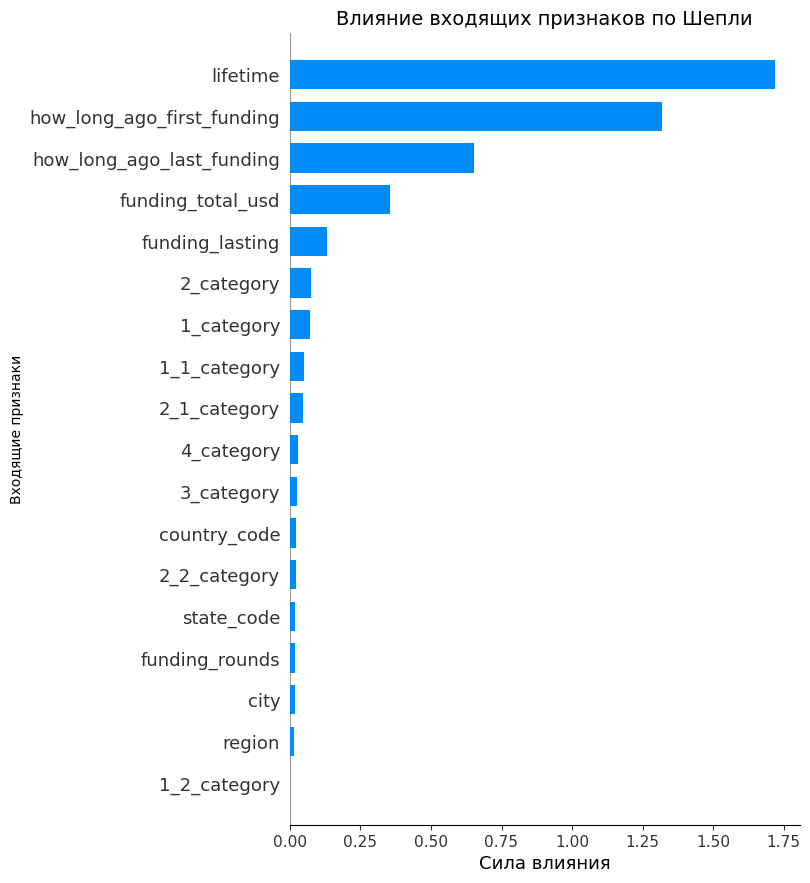

In [83]:
# вывод графика
shap.summary_plot(shap_values, all_input_features, plot_type="bar", max_display=30, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.set_title('Влияние входящих признаков по Шепли', fontdict={"size":14})
ax.set_ylabel('Входящие признаки')
ax.set_xlabel('Сила влияния')
plt.show()

### Выводы по этапу моделирования:

- использование входящих признаков "как есть", без добавления новых (которые описаны в разделе 2.3.5), дает качество модели 60-65% по f1 метрике (на тестовой выборке), не более, вне зависимости от того, какая модель используется (tree, forest, lgbm, catboost);
- добавление обработанного признака "category_list" (отрасль стартапа) дает следующий потолок качества - 70-75%;
- добавление нового признаков  'how_long_ago_first_funding' и 'how_long_ago_last_funding' - дает следующий прыжок до 89%;


- без добавления новых признаков, даже примитивные модели дают сносное качество на тренировочной (80-90 без всякого бустинга), но сильно проседают на тестовой (до тех самых 60%), при этом никакая регуляризация не помогает (даже в продвинутых моделях), хотя кажется, что это как раз такой случай - высокое качество на тренировочной - низкое на тестовой - значит нужна регуляризация. **Но это СОВСЕМ не так - нужны именно дополнительные features** для роста качества модели на тестовой выборке;


- для продвинутых моделей (lgbm, catboost) сэмплинг не нужен вообще - хотя здесь большая диспропорция между классами (90/10);
- андерсэмплинг даже снижает качество;
- оверсэмплинг оставляет на том же уровне практически;
- в простых моделях (дерево) оверсэмплинг поднимает качество;


- отсеивание выбросов, фильтрация данных, которые не встречаются  в тестовой выборке - только ухудшают качество (пробовал на этапе без дополнительных features прогонять данные тренировочной выборки - через еще одну классификационную модель, на предмет того, насколько они похожи на значения тестовой - но даже такое отсеивание только ухудшает, причем значительно);
- упрощение категориальных данных (оставить только самые частотные, остальное - none) - тоже ухудшает качество на тестовой;
- уборка неявных дублей в категориальных данных (города, регионы) - не дает существенного роста качества (но зато алгоритмы их поиска забирают очень много времени)


- касательно обработки признака "category_list" - существенное значение имеют категории первого уровня (которые указываются через разделитель | в оригинале), глубиной до 3 словосочетаний (т. е. не более 3 словосочетаний); 
- в случае категорий второго уровня (где разделителем выступает пробел - или просто отдельные слова) - имеют заметное влияние только от категорий 1 и 2, и глубиной не более 2 (т. е. не более двух первых слов);
- дальнейшее добавление (слов или словосочетаний) ведет к ухудшению качества на тестовой выборке;


- самые лучшие показатели на тестовой выборке у модели catboost с 1000 деревьев, глубиной 5 и регуляризацией L2=1 - 89,683%;
- после обсчета на 50% тестовой выборки (после дедлайна соревнования), качество модели с 1000 деревьев проседает всего на 0,05%, до 89,633;
- дальнейшее увеличение характеристик модели ведет уже к ухудшению качества;
- выше приведен код с 100 деревьев и глубиной 5 - для лучшей скорости расчета, и такая модель дает 88% качество, что с практической точки зрения не намного худший результат.

In [84]:
# вывод результатов в формате для соревнования kaggle

y_pred = model.predict(test_data[all_input_features])
test_data['status'] = pd.DataFrame(y_pred)
test_data ['status'] = test_data['status'].apply(lambda x: 'operating' if x == 1 else 'closed')
feedback = test_data [['name', 'status']]
feedback.to_csv(r'datasets\feedback.csv', index=False)

### Портрет живого (operating) стартапа

In [85]:
# выгрузим вероятности принадлежности к классам (operating/closed) для тренировочной выборки
probabilities = model.predict_proba(train_data[all_input_features])[:, 1]
train_data['proba'] = probabilities

In [86]:
# создадим пользовательскую функцию, которая будет отображать график:
# по оси абсцисс - входящий признак, по оси ординат - вероятность отнесения к мажорному классу (operating)

def describing (dataset, incoming_feature, target_feature):     
    
    probabilities_range = np.arange(0.5, 1.0, 0.1)
    mean_feature_values = []

    for prob in probabilities_range:
        mean_feature = dataset.query(f'{target_feature} > {prob}')[incoming_feature].mean()
        mean_feature_values.append(mean_feature)

    result_df = pd.DataFrame({'Probability': probabilities_range, 'Mean Feature': mean_feature_values})


    plt.plot(result_df['Mean Feature'], result_df['Probability'], marker='o')

    plt.xlabel(f'Среднее значение {incoming_feature}')
    plt.ylabel('Вероятность')
    plt.title(f'Вероятность отнесения к классу operating в зависимости от значения {incoming_feature}')
    plt.grid(True)
    plt.show()

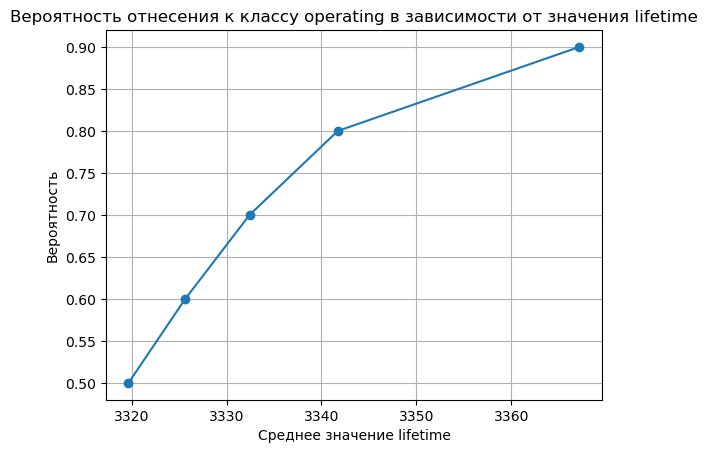

In [87]:
# критичное значение времени жизни для выживаемости стартапа
describing (train_data, 'lifetime', 'proba')     

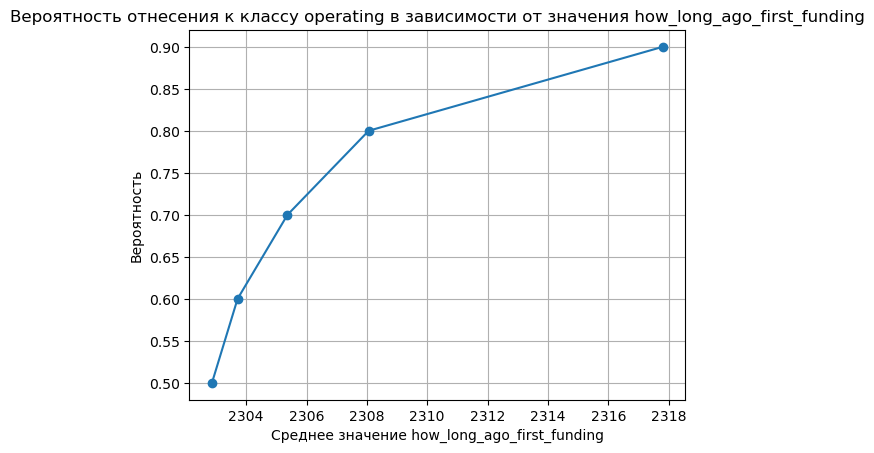

In [88]:
# критичное значение времени с момента первого раунда для выживаемости стартапа
describing (train_data, 'how_long_ago_first_funding', 'proba') 

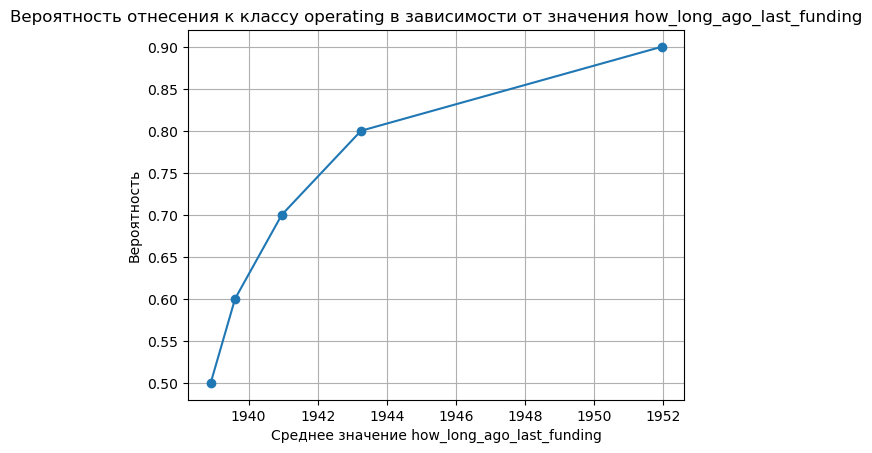

In [89]:
# критичное значение времени с момента первого раунда для выживаемости стартапа
describing (train_data, 'how_long_ago_last_funding', 'proba') 

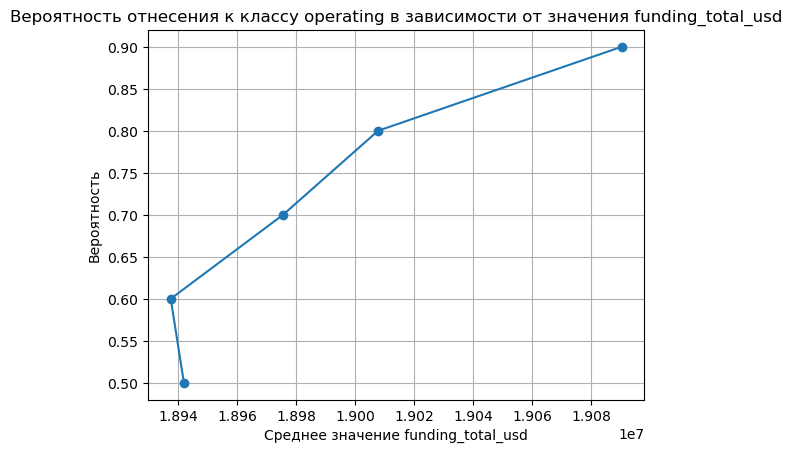

In [90]:
# критичное значение полученного объема финансирования для выживаемости стартапа
describing (train_data, 'funding_total_usd', 'proba')     

Здесь мы видим, что для того чтобы быть стартапом, который не помрет, надо:
- надо проработать минимум 9 лет;
- привлечь хотя бы 19 млн. долл.
- проработать порядка 6 лет после первого раунда привлечения средств;
- проработать порядка 5 лет после последнего раунда привлечения средств.

Если вы удовлетворяете этим критерияем как стартап - значит вы, скорее всего, выжили на рынке.

In [91]:
# визуализируем кто входит в первую десятку стран по частотности, среди стартапов, у которых вероятность выживания выше 50%
train_data.query('proba > 0.5')['country_code'].value_counts(normalize=True).head(10)

country_code
USA    0.631854
GBR    0.062001
CAN    0.032907
IND    0.028027
CHN    0.027142
FRA    0.019585
DEU    0.017702
ISR    0.015954
ESP    0.012890
NLD    0.008102
Name: proportion, dtype: float64

В тройке лидеров ожидаемо находятся США, Великобритания и Канада.
Новостью для меня оказалось положени Индии - сразу после тройки лидеров и выше Китая и европейских стран.
Замыкают этот топ Франция, Германия, Израиль, Испания и Нидерланды (вполне ожидаемо).

Вышеуказанные страны составляют порядка 80% всех стартапов, среди тех, вероятность которых отнесения к operating выше 50%.
Соответственно чтобы быть стартапом, "который выжил" - лучше всего быть стартапом из США, или Северной Америки (банально, но факт, можно сказать "медицинский факт").

In [92]:
# визуализируем кто входит в первую десятку стран по частотности, среди стартапов, у которых вероятность выживания выше 50%
train_data.query('proba > 0.5')['1_1_category'].value_counts(normalize=True).head(10)

1_1_category
Biotechnology    0.074556
Software         0.066529
Health           0.045991
E-Commerce       0.043974
Advertising      0.039896
Curated          0.030861
Mobile           0.030518
Analytics        0.027148
Clean            0.023886
Apps             0.023350
Name: proportion, dtype: float64

И судя по отраслям, самыми живучими (или самыми востребованными на рынке за 1970-2018, по сути) были стартапы из отрасли биотехнологий, программного обеспечения, здравоохранения и электронной коммерции. Господи, и тут никуда без WB )

# Общие выводы

- (1) Целью данной работы было разработать модель прогнозировования состояния стартапа (дейсвует/закрылся);
- (2) Лучшей моделью для прогнозирования оказалась catboost;
- (3) качество модели по метрике f1 на тренировочной выборке - 99%, на тестовой - 89%; 

Самыми важными входящими признаками для прогнозирования состояния являются (указаны по мере убывания):
- (1) время жизни стартапа;
- (2) общий объем финансирования;
- (3) как давно (относительно текущего момента времени) был первый и последний раунд финансирования;
- (4) в какой отрасли работал стартап (решающее значение в описании отрасли играет первое слово и первое словосочетание);
- (5) географическое местоположение стартапа.

Критичными значениями вышеуказанных входящих признаков являются (и куда уже можно инвестировать скорее всего с намного меньшим риском):
- стартап должен проработать минимум 9 лет;
- должен привлечь не менее 19 млн. долл.;
- должен проработать порядка 6 лет после первого раунда привлечения средств;
- должен проработать порядка 5 лет после последнего раунда привлечения средств.